In [2]:
import random
import math
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [3]:
def random_sine(samples=50, max_amp=1, min_amp=0, max_freq=5, min_freq=0.2, freq_chaos=0.3, amp_chaos=0.1):
  phase = random.uniform(0, math.pi * 2)
  amp = random.uniform(min_amp, max_amp)
  offset = random.uniform(1-amp, amp-1)
  freq = random.uniform(min_freq, max_freq)
  phase_incr = 2 * freq * math.pi / samples
  output = []

  for _ in range(samples):
    phase += phase_incr
    output.append(math.sin(phase) * amp + offset)
    if random.random() < amp_chaos:
      amp = random.uniform(min_amp, max_amp)
      offset = random.uniform(1-amp, amp-1)
    if random.random() < freq_chaos:
      freq = random.uniform(min_freq, max_freq)
      phase_incr = 2 * freq * math.pi / samples

  return output

In [4]:
def random_nums(samples=50):
  return [random.random() for _ in range(samples)]

In [5]:
def permute_signal(signal, size_reduction = 3, max_pad = 5):
  # remove some points
  new_signal = list(signal)

  for i in range(size_reduction):
    point = random.randint(0, len(new_signal) - 1)
    del new_signal[point]

  # add interpolations
  for i in range(size_reduction):
    point = random.randint(1, len(new_signal) - 1)
    interp = (new_signal[point - 1] + new_signal[point]) / 2
    new_signal.insert(point, interp)

  # add noise
  for i in range(len(new_signal)):
    new_signal[i] += random.uniform(-0.05, 0.05)

  # add some zero padding in the beginning
  pad_num = random.randint(0, max_pad)
  padding = [0 for _ in range(pad_num)]
  new_signal = padding + new_signal[:len(new_signal) - pad_num]

  return new_signal
    

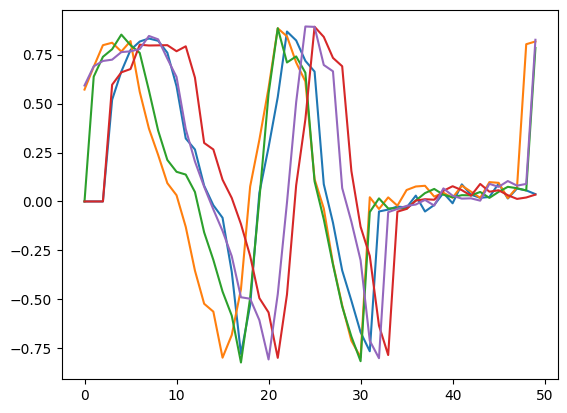

In [6]:
sequence = random_sine()
for _ in range(5):
  plt.plot(permute_signal(sequence))

In [7]:
def generate_data(sample_size=50, batch_size=6):
  X = torch.tensor([random_nums(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))
  
  y = torch.tensor([random_sine(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))

  return X, y


# MODEL

In [8]:
class LSTMMemory(torch.nn.Module):

  def __init__(self, hidden_size, input_size=1, output_size=1):
    super().__init__()
    self._scaler = StandardScaler()
    self._hidden_state = None
    self.lstm = torch.nn.LSTM(
        input_size = input_size,
        hidden_size = hidden_size,
        batch_first = True
    )
    self.linear = torch.nn.Linear(
            in_features=hidden_size,
            out_features=output_size
        )

  def forward(self, x):
    h = self.lstm(x)[0]

    return self.linear(h)

  def forward_live(self, x):
    
    x = torch.tensor(self._scaler.transform(x).reshape((1, 1)).astype(np.float32))
    if self._hidden_state:
      h, self._hidden_state = self.lstm(x, self._hidden_state)
    else:
      h, self._hidden_state = self.lstm(x)

    return self.linear(h)
  
  def reset_live(self):
    self._hidden_state = None

  def fit(self, data):
    self._scaler.fit(data)

  def fit_transform(self, data):
    return self._scaler.fit_transform(data)


# OTHER SETUP

In [9]:
def curve_plot(rows, cols, X, y, prefix=""):
  axs = (plt.figure(constrained_layout=True)
      .subplots(rows, cols, sharex=True, sharey=True))
  
  if rows > 1:
    for i in range(rows):
      if cols > 1:
        for j in range(cols):
          axs[i][j].set(title = f"{prefix}Input {j}, output {i}")
          axs[i][j].plot(X[:, :, j].tolist()[0], label=f"input {j}")
          axs[i][j].plot(y[:, :, i].tolist()[0], label=f"output {i}")
      else:
        axs[i].set(title = f"{prefix}Input, output {i}")
        axs[i].plot(X[:, :, 0].tolist()[0], label=f"input")
        axs[i].plot(y[:, :, i].tolist()[0], label=f"output {i}")

  else:
    if cols > 1:
      for j in range(cols):
          axs[j].set(title = f"{prefix}Input {j}, output")
          axs[j].plot(X[:, :, j].tolist()[0], label=f"input {j}")
          axs[j].plot(y[:, :, 0].tolist()[0], label=f"output")
    else:
      axs.set(title = f"{prefix}Input, output")
      axs.plot(X.tolist()[0], label=f"input")
      axs.plot(y.tolist()[0], label=f"output")

  print("Blue inputs, orange outputs")
  plt.show()

# TESTING

## Random sine -> permuted random sine

In [10]:
def generate_randnums_permutedsines(sample_size=50, batch_size=6):
  X = torch.tensor([random_nums(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))
  
  y = torch.tensor([random_sine(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))

  return X, y

Blue inputs, orange outputs


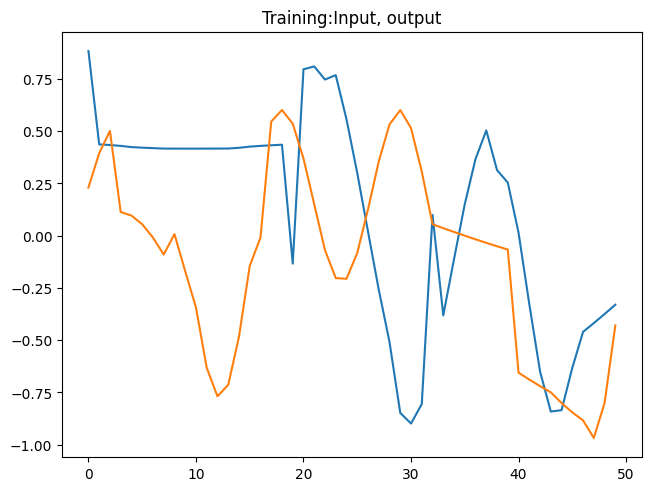

Blue inputs, orange outputs


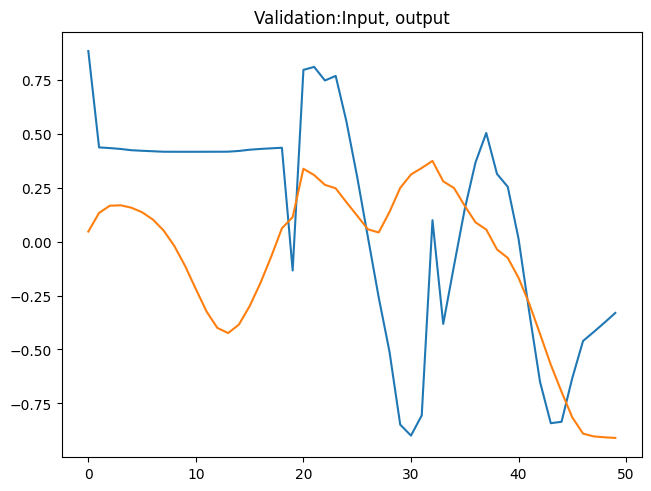

Blue inputs, orange outputs


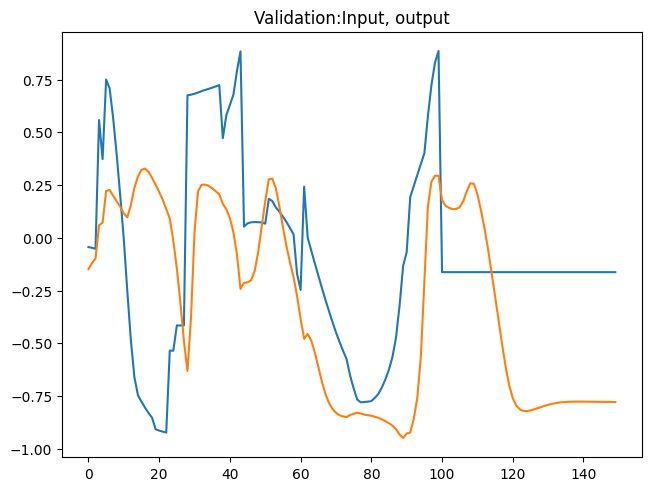

Blue inputs, orange outputs


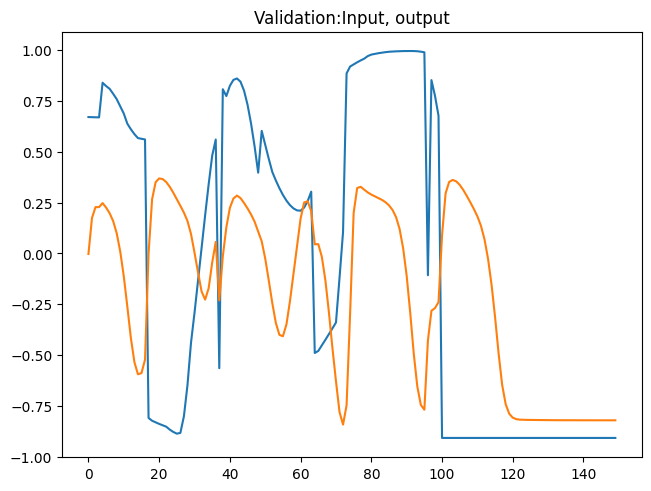

Blue inputs, orange outputs


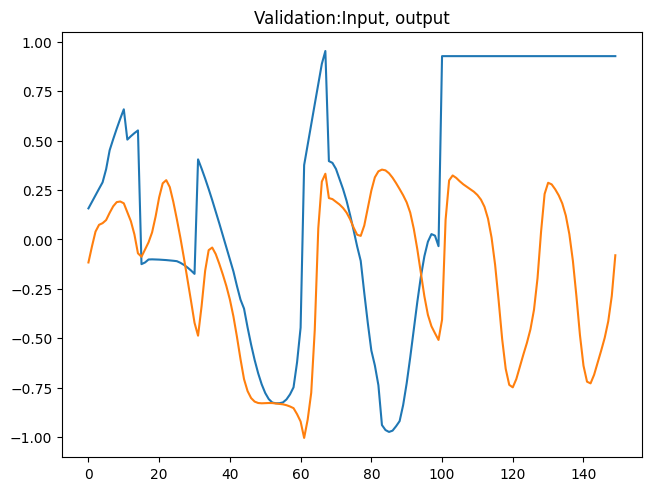

Blue inputs, orange outputs


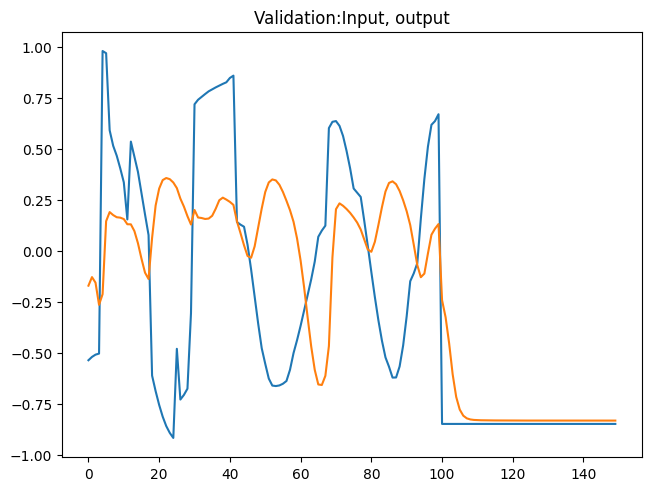

Blue inputs, orange outputs


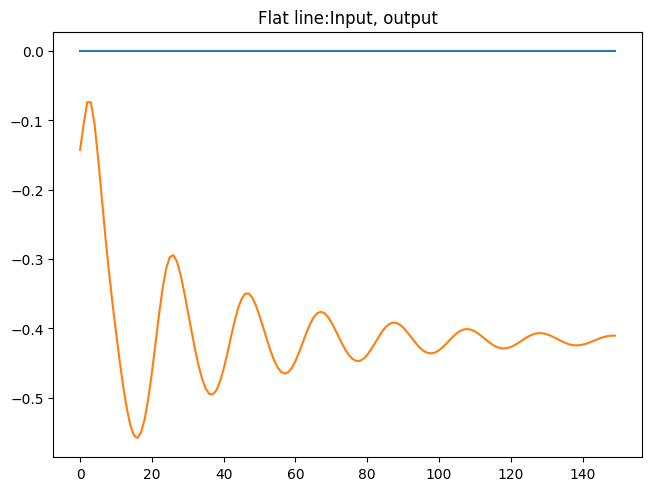

In [11]:
random.seed(45)
torch.manual_seed(42)

model = LSTMMemory(15)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=.02)
model.train()
x_list = random_sine(50)
X = torch.tensor([x_list for _ in range(6)]).reshape((6, 50, 1))
y_list = [point * 1 for point in random_sine(50)]
curve_plot(1, 1, X, torch.tensor(y_list).reshape(1, 50, 1), "Training:")

for j in range(500):
  optimizer.zero_grad()
  pred = model(X)
  y = torch.tensor([permute_signal(y_list) for _ in range(6)]).reshape((6, 50, 1))

  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  
  # print(f"Loss = {loss} but why do I care?")
model.eval()
with torch.no_grad():
  val_y = model(X)
curve_plot(1, 1, X, val_y, "Validation:")

for i in range(4):
  with torch.no_grad():
    finisher = random.uniform(-1, 1)
    test_X = torch.tensor((random_sine(100) + [finisher for _ in range(50)])).reshape((1, 150, 1))
    test_predicted_y = model(test_X)
  curve_plot(1, 1, test_X, test_predicted_y, "Validation:")

with torch.no_grad():
  test_X = torch.tensor([0 for _ in range(150)]).reshape((1, 150, 1)).float()
  test_predicted_y = model(test_X)
curve_plot(1, 1, test_X, test_predicted_y, "Flat line:")



# N random sines -> M random permuted sines

Blue inputs, orange outputs


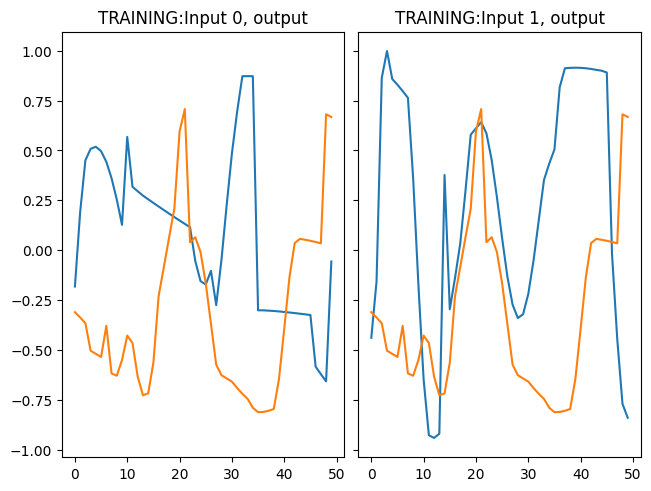

Blue inputs, orange outputs


/var/folders/1k/lvlt8xp56tb77wg9bnkzn3gh0000gq/T/ipykernel_29798/1480512236.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  curve_plot(outputs, inputs, X, torch.tensor(val_pred_y).reshape((6, 50, outputs)), "VALIDATION:")


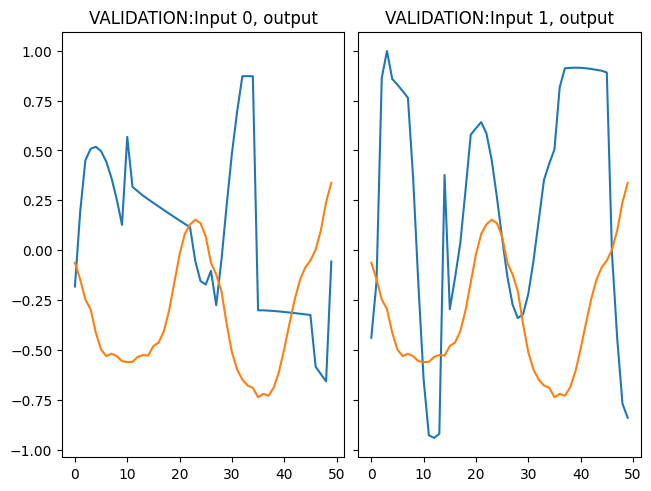

Blue inputs, orange outputs


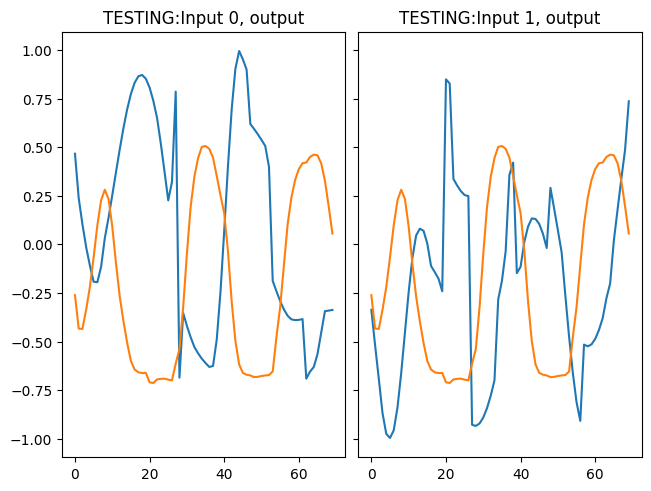

Blue inputs, orange outputs


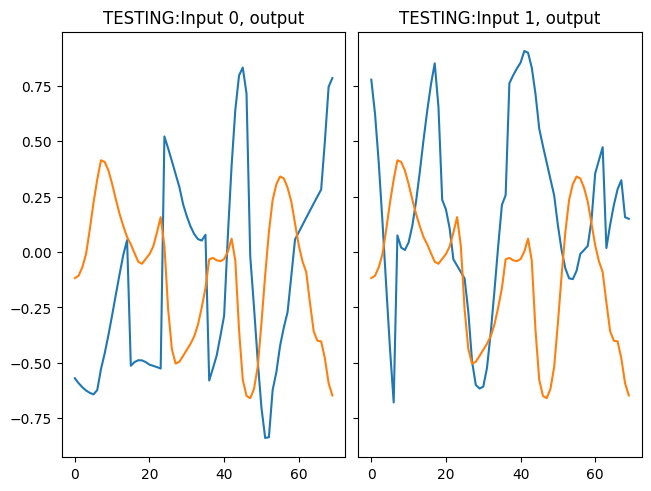

Blue inputs, orange outputs


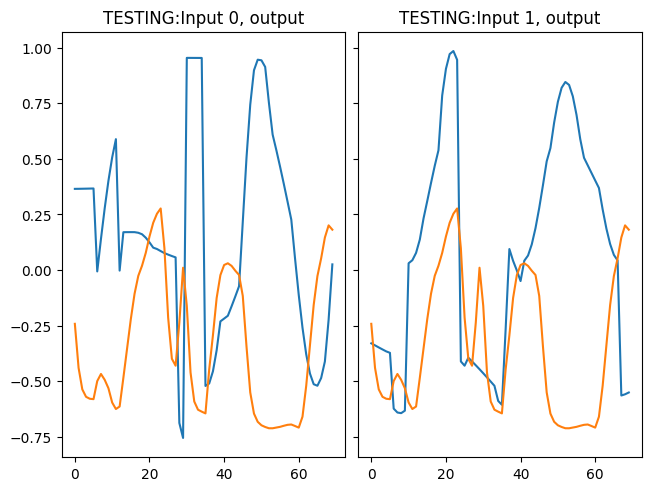

Blue inputs, orange outputs


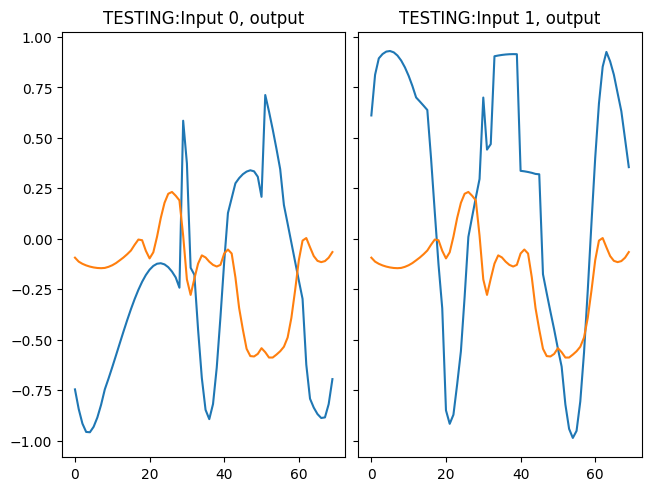

Predicted:  [[[-0.09361673146486282], [-0.11327306926250458], [-0.12409448623657227], [-0.13197533786296844], [-0.13788491487503052], [-0.1420793980360031], [-0.14474596083164215], [-0.1457604467868805], [-0.14439958333969116], [-0.138998344540596], [-0.13113164901733398], [-0.12043093144893646], [-0.10681165009737015], [-0.09274511784315109], [-0.07654639333486557], [-0.05825699865818024], [-0.02960597537457943], [-0.0038333963602781296], [-0.007183810696005821], [-0.05963923782110214], [-0.09727944433689117], [-0.0670008733868599], [0.010604353621602058], [0.10324040800333023], [0.1780557632446289], [0.2230534553527832], [0.23209013044834137], [0.21343901753425598], [0.1903165876865387], [0.015071207657456398], [-0.20125222206115723], [-0.27815914154052734], [-0.19794128835201263], [-0.12307501584291458], [-0.08224262297153473], [-0.0925186425447464], [-0.1135922372341156], [-0.12940476834774017], [-0.1374789923429489], [-0.12930139899253845], [-0.07292833179235458], [-0.053316801786

In [13]:
inputs = 2
outputs = 1

random.seed(20)
torch.manual_seed(41)

model_2d_2d = LSTMMemory(15, inputs, outputs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model_2d_2d.parameters(), lr=.02)
model_2d_2d.train()
X_list = list(zip(*[random_sine(50) for _ in range(inputs)]))
X = torch.tensor([X_list for _ in range(6)]).float()
y_list_pure = [random_sine(50) for _ in range(outputs)]

for j in range(500):
  optimizer.zero_grad()
  pred = model_2d_2d(X)
  
  y_list = list(zip(*[permute_signal(y) for y in y_list_pure]))
  y = torch.tensor([y_list for _ in range(6)]).reshape((6, 50, outputs))
  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  
  # print(f"Loss = {loss}")
model_2d_2d.eval()

true_y = list(zip(*y_list_pure))
curve_plot(outputs, inputs, X, torch.tensor(true_y).reshape((1, 50, outputs)), "TRAINING:")

val_pred_y = model_2d_2d(X)
curve_plot(outputs, inputs, X, torch.tensor(val_pred_y).reshape((6, 50, outputs)), "VALIDATION:")



for i in range(4):
  with torch.no_grad():
    test_X_list = list(zip(*[random_sine(70) for _ in range(inputs)]))
    test_X = torch.tensor(test_X_list).reshape((1, 70, inputs))
    test_predicted_y = model_2d_2d(test_X)
  curve_plot(outputs, inputs, test_X, test_predicted_y, "TESTING:")
print("Predicted: ", test_predicted_y.tolist())

# Time since last note + velocity from Bonk

In [ ]:
from sklearn import preprocessing
from math import log

TIMES


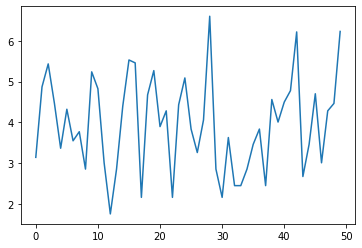

VELS


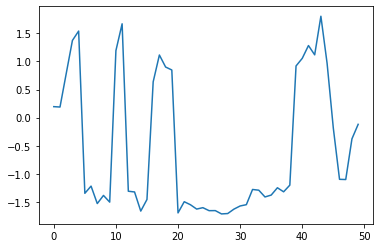

In [ ]:
with open('/content/drive/MyDrive/rnn_improv/time_vel.txt') as f:
  txt = f.readlines()
model = LSTMMemory(15)
data_pts = []
times = []
vels = []

for pt in txt:
  time, vel = pt.split(' ')
  time = log(float(time))
  vel = float(vel[:-2])
  data_pts.append([time, vel])
  times.append(time)
  vels.append(vel)

times = times
scaled_vels = preprocessing.scale(vels)
scaled_vels2 = model.fit_transform(np.array(vels).reshape(len(vels), 1))
data_pts_np = np.array(data_pts)

print("TIMES")
plt.figure()
plt.plot(times[:50])
plt.show()
print("VELS")
plt.figure()
plt.plot(scaled_vels[:50])
plt.show()

### Training with just velocity

Loss = 0.08166658133268356 but why do I care?
Loss = 0.0741710364818573 but why do I care?
Loss = 0.046233613044023514 but why do I care?
Loss = 0.05332297086715698 but why do I care?
Loss = 0.04161492735147476 but why do I care?
Loss = 0.03500502184033394 but why do I care?
Loss = 0.041337307542562485 but why do I care?
Loss = 0.021333813667297363 but why do I care?
Loss = 0.030593596398830414 but why do I care?
Loss = 0.031215811148285866 but why do I care?
INPUT:


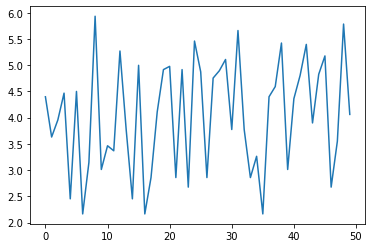

OUTPUT:


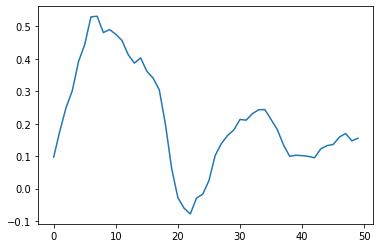

INPUT:


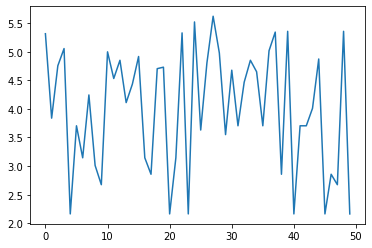

OUTPUT:


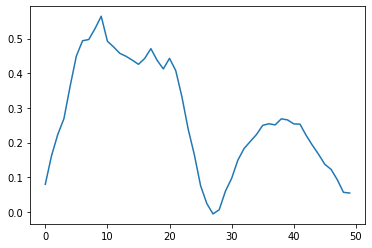

INPUT:


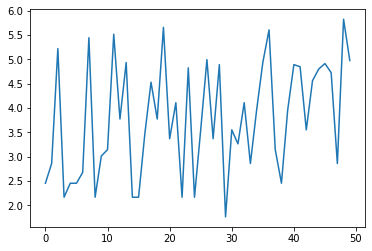

OUTPUT:


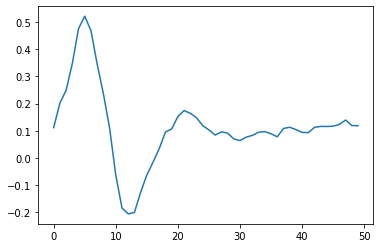

INPUT:


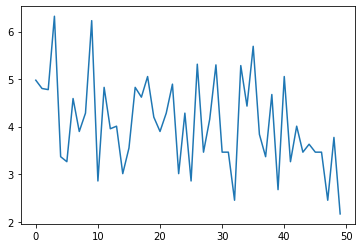

OUTPUT:


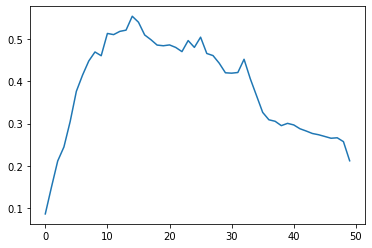

Predicted:  [[[0.08629865199327469], [0.1500260978937149], [0.21148093044757843], [0.2446466088294983], [0.3044555187225342], [0.3761143684387207], [0.41454797983169556], [0.44785425066947937], [0.46918973326683044], [0.46032002568244934], [0.5129738450050354], [0.510251522064209], [0.5178837180137634], [0.5208009481430054], [0.5536704063415527], [0.5395660996437073], [0.5094207525253296], [0.4982736110687256], [0.4855287969112396], [0.4838847815990448], [0.485872745513916], [0.4798910915851593], [0.4700249433517456], [0.4961727261543274], [0.48003894090652466], [0.5041553974151611], [0.4656250774860382], [0.4606890380382538], [0.44268929958343506], [0.41996654868125916], [0.4190766513347626], [0.42064204812049866], [0.45192039012908936], [0.4059818685054779], [0.36616459488868713], [0.3263036608695984], [0.3088543713092804], [0.30531957745552063], [0.29502296447753906], [0.3004029095172882], [0.29668840765953064], [0.2876449525356293], [0.28232476115226746], [0.27645957469940186], [0.

In [ ]:
random.seed(41)
torch.manual_seed(42)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=.02)
model.train()
x_list = times[:50]
X = torch.tensor([x_list for _ in range(6)]).reshape((6, 50, 1)).float()
y_list = random_sine(50)
for j in range(500):
  optimizer.zero_grad()
  pred = model(X)
  y = torch.tensor([permute_signal(y_list) for _ in range(6)]).reshape((6, 50, 1))

  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  if j % 50 == 49:
    print(f"Loss = {loss} but why do I care?")
model.eval()


for i in range(4):
  with torch.no_grad():
    test_X = torch.tensor(times[(i + 1) * 50:(i + 2) * 50]).reshape((1, 50, 1)).float()
    test_predicted_y = model(test_X)
  print("INPUT:")
  plt.figure()
  plt.plot(test_X.tolist()[0])
  plt.show()
  print("OUTPUT:")
  plt.figure()
  plt.plot(test_predicted_y.tolist()[0])
  plt.show()
plt.show()
print("Predicted: ", test_predicted_y.tolist())

## Training with velocity and time since last note

In [ ]:
plt.hist(np.array(data_pts)[:, 0])

In [ ]:
X_row[:, 0].tolist()[0]

-0.7275133851621666

In [ ]:
data_pts_np = np.array(data_pts)

Loss = 0.05835835263133049 but why do I care?
Loss = 0.05849725753068924 but why do I care?
Loss = 0.06742596626281738 but why do I care?
Loss = 0.06599811464548111 but why do I care?
Loss = 0.05475466325879097 but why do I care?
Loss = 0.07875889539718628 but why do I care?
Loss = 0.0775640457868576 but why do I care?
Loss = 0.04715963825583458 but why do I care?
Loss = 0.07088053226470947 but why do I care?
Loss = 0.06871214509010315 but why do I care?


TypeError: ignored

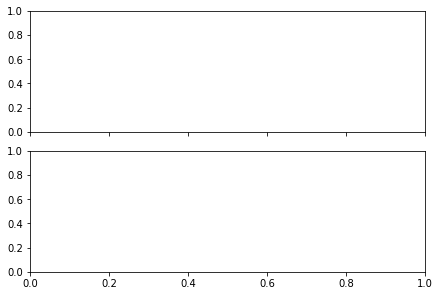

In [ ]:
random.seed(39)
torch.manual_seed(42)

model_2d = LSTMMemory(15, 2, 1)
scaled_data = torch.tensor(model_2d.fit_transform(preprocessing.scale(data_pts_np)))
X_row = scaled_data[:50]
X = X_row.repeat(6, 1, 1)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model_2d.parameters(), lr=.02)
model_2d.train()

y_list = random_sine(50)
for j in range(500):
  optimizer.zero_grad()
  pred = model_2d(X.float())
  y = torch.tensor([permute_signal(y_list) for _ in range(6)]).reshape((6, 50, 1))

  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  if j % 50 == 49:
    print(f"Loss = {loss} but why do I care?")
model.eval()

y_tensor = torch.tensor(y_list)
curve_plot(2, 1, X, y_tensor, f"Training:")

for i in range(4):
  with torch.no_grad():
    test_X = scaled_data[(i + 1) * 50:(i + 2) * 50].reshape(1, 50, 2).float()
    test_predicted_y = model_2d(test_X)

  axs = (plt.figure(constrained_layout=True)
      .subplots(1, 2, sharex=True, sharey=True))
  axs[0].set(title="TESTING Time since last note vs output")
  axs[1].set(title="TESTING Velocity vs output")
  axs[0].plot(test_X[:, :, 0].tolist()[0])
  axs[0].plot((test_predicted_y * 2).tolist()[0])
  axs[1].plot(test_X[:, :, 1].tolist()[0])
  axs[1].plot((test_predicted_y * 2).tolist()[0])
  plt.show()
print("Predicted: ", test_predicted_y.tolist())

## velocity and time since last note to 2 outputs

Loss = 0.171090230345726
Loss = 0.10751083493232727
Loss = 0.11848318576812744
Loss = 0.11039496213197708
Loss = 0.16187411546707153
Loss = 0.11235300451517105
Loss = 0.16008684039115906
Loss = 0.13467659056186676
Loss = 0.11633073538541794
Loss = 0.11709760129451752
Blue inputs, orange outputs


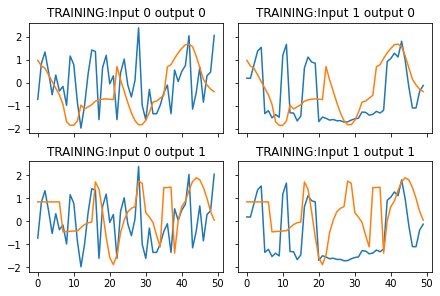

Blue inputs, orange outputs


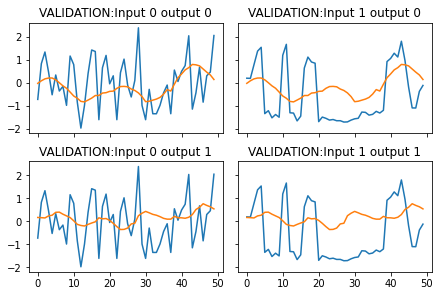

Blue inputs, orange outputs


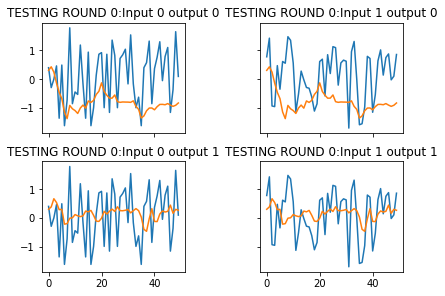

Blue inputs, orange outputs


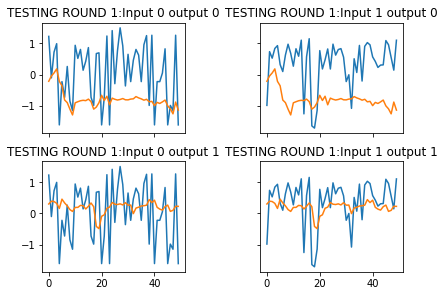

Blue inputs, orange outputs


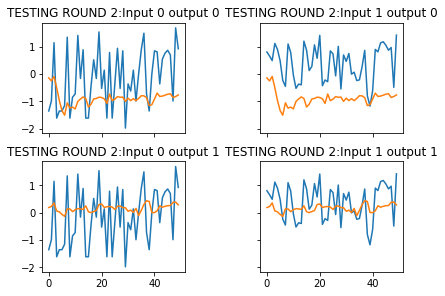

Blue inputs, orange outputs


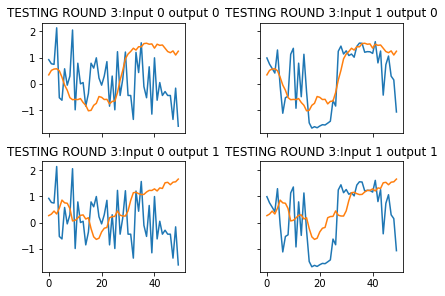

In [ ]:
random.seed(25)
torch.manual_seed(42)

model_2d = LSTMMemory(15, 2, 3)
scaled_data = torch.tensor(model_2d.fit_transform(preprocessing.scale(data_pts_np)))
X_row = scaled_data[:50]
X = X_row.repeat(6, 1, 1)

y_lists = [random_sine(50) for _ in range(3)]

criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model_2d.parameters(), lr=.02)
model_2d.train()

for j in range(500):
  optimizer.zero_grad()
  pred = model_2d(X.float())

  y_lists_permuted = list(zip(*[permute_signal(y) for y in y_lists]))
  y = torch.tensor([y_lists_permuted for _ in range(6)]).reshape((6, 50, 3))

  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  if j % 50 == 49:
    print(f"Loss = {loss}")
model.eval()

y_tensor = torch.tensor(list(zip(*y_lists))).reshape(1, 50, 3)
curve_plot(2, 2, X, y_tensor * 2, prefix="TRAINING:")

curve_plot(2, 2, X, model_2d(X.float()), prefix="VALIDATION:")

for i in range(4):
  with torch.no_grad():
    test_X = scaled_data[(i + 1) * 50:(i + 2) * 50].reshape(1, 50, 2).float()
    test_predicted_y = model_2d(test_X)
  curve_plot(2, 2, test_X, test_predicted_y * 2, prefix=f"TESTING ROUND {i}:")

### Saving

In [ ]:
torch.save(model_2d, "/content/drive/MyDrive/rnn_improv/vel_time1.pt")

# Testing for live usage

In [ ]:
live_outputs = []
test_live_X = torch.tensor(vels[200:250]).reshape((1, 50, 1)).float()

with torch.no_grad():
  model.reset_live()
  for i in range(50):
    live_out = model.forward_live(test_live_X[:, i, :])
    live_outputs.append(live_out.item())

plt.plot(live_outputs)



In [ ]:
live_outputs = []
test_live_X = torch.tensor(vels[200:250]).reshape((1, 50, 1)).float()

with torch.no_grad():
  model.reset_live()
  for i in range(50):
    live_out = model.forward_live(torch.tensor([random.uniform(0, 1)]).reshape(1, 1))
    live_outputs.append(live_out.item())

plt.plot(live_outputs)

In [ ]:
test_live_X[:, 1, :]

In [ ]:
torch.rand((1, 1, 1))